This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/odometry.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [78]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [79]:
import torch
import numpy as np
import pandas as pd

from typing import Any, Dict, List, Tuple, Callable, Optional, Union
from tqdm.notebook import tqdm
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker

rcParams["figure.figsize"] = (15, 5)
rcParams["figure.autolayout"] = True

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [80]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry


In [81]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
EVALUATION_FOLDER = EXPERIMENT_FOLDER / 'evaluation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

C:\Users\esdan\Desktop\AO\models


## Generate recording ground truth

The recording is composed by audio files from several devices that span for the
whole experiment and several wheel test bed control files that span for certain
parts of the experiment. In this section we combine the control files in order
to generate a unique ground truth for the whole recording.


In [82]:
# Get the first evaluation recording found in hte folder
for folder in EVALUATION_FOLDER.iterdir():
    if folder.is_dir():
        recording = folder
        break
else:
    raise RuntimeError(
        f'No evaluation recording found in {EVALUATION_FOLDER}'
        )

In [83]:
def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    """Get the start and end timestamp of a recording from its audio files

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files

    Returns:
        Tuple[float, float]: start and end timestamps
    """
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp


get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

In [84]:
def generate_recording_ground_truth(recording: Path) -> pd.DataFrame:
    """Generates the ground truth of a recording from its control files

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'X', 'Vx',
        'Vw', 'slip', 'wheel_rotation'
    """
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.loc[:, 'X'] /= 1000  # [mm] -> [m]
    gt['tx'] = gt['X'].diff()
    gt.iloc[0, gt.columns.get_loc('tx')] = 0
    return gt

,X,Vx,Vw,slip,wheel_rotation,tx
timestamp,,,,,,
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000,0.00000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397,0.00000
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520,0.00011
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300,0.00118
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400,0.00242


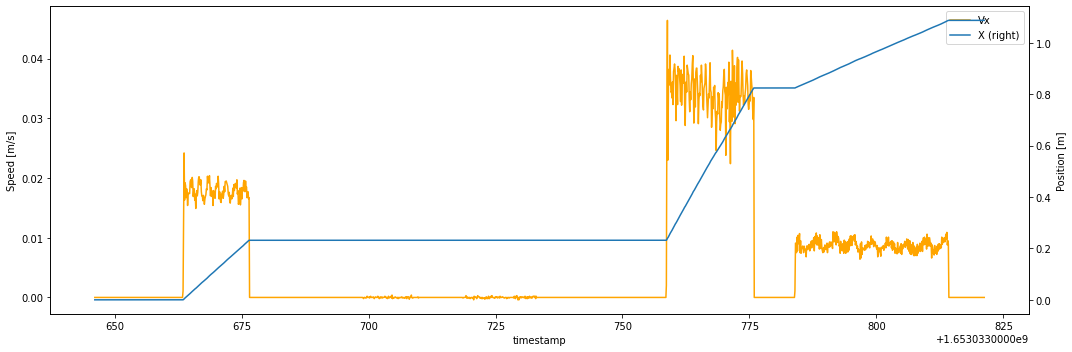

In [85]:
def get_recording_ground_truth(
        recording: Path, force_generation: bool = False
    ) -> pd.DataFrame:
    """Gets the ground truth corresponding to a recording

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files
        force_generation (bool, optional): Force generation instead of loading
            from file. Defaults to False.

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'X', 'Vx',
        'Vw', 'slip', 'wheel_rotation'
    """
    ground_truth_path = recording / 'ground_truth.csv'
    if not force_generation and ground_truth_path.exists():
        gt = pd.read_csv(ground_truth_path, index_col='timestamp')
    else:
        gt = generate_recording_ground_truth(recording)
        gt.to_csv(ground_truth_path, index_label='timestamp')
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
ground_truth.head()

## Generate odometry with model


In [86]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cuda device


In [87]:
extractors = [
    ao.extractor.GammatoneFilterbank(
        num_samples=int(10 * 44100 / 1000),
        num_features=256,
        sample_rate=44100,
        )
    ]
model = ao.AO(
    model_path=MODELS_FOLDER /
    'torch-script;name_numpy-arrays;date_2022-05-23;time_13-39-14.pt',
    extractors=extractors,
    num_frames=120,
    )

In [88]:
def generate_odometry(
        wav_file: Path,
        model: ao.AO,
        pbar: Optional[tqdm] = None
    ) -> pd.DataFrame:
    """Generates odometry from a wav file using the provided model

    Args:
        wav_file (Path): Audio recording in wav format
        model (ao.AO): Acoustic Odometry model
        pbar (Optional[tqdm]): Progress bar to display. If False, no progress
            bar is displayed.

    Returns:
        pd.DataFrame: Odometry data with columns 'Vx', 'tx' and 'X'
    """
    wav_data, _ = ao.io.wave_read(wav_file)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    step = model.num_samples / model.sample_rate
    frames = ao.dataset.audio._frames(
        wav_data.mean(axis=1)[:, np.newaxis], model.num_samples
        )
    timestamps = np.linspace(start, start + len(frames) * step, len(frames))
    Vx = np.zeros(len(frames))
    if pbar is False:
        for i, frame in pbar(enumerate(frames)):
            Vx[i] = model(frame)
    else:
        if pbar is None:
            pbar = tqdm(unit='frames')
        pbar.set_description(f"{wav_file.parent.name}/{wav_file.stem}")
        pbar.reset(total=len(frames))
        for i, frame in enumerate(frames):
            Vx[i] = model(frame)
            pbar.update()
    # Compute X translations and cumulative X position
    Vx = pd.Series(Vx, index=timestamps) / 100  # [cm/s] -> [m/s]
    odom = pd.concat([Vx, Vx.index.to_series().diff() * Vx], axis=1)
    odom.columns = ['Vx', 'tx']
    odom.iloc[0, :] = 0
    odom['X'] = odom['tx'].cumsum()
    return odom

In [89]:
def get_odometry(
        wav_file: Path,
        model: ao.AO,
        pbar: Optional[tqdm] = None,
        force_generation: bool = False
    ) -> pd.DataFrame:
    """Gets the odometry data corresponding to a wav file and model

    Args:
        wav_file (Path): Audio recording in wav format
        model (ao.AO): Acoustic Odometry model
        pbar (Optional[tqdm]): Progress bar to display. If False, no progress
            bar is displayed.
        force_generation (bool, optional): Force generation instead of loading
            from file. Defaults to False.

    Returns:
        pd.DataFrame: Odometry data with columns 'Vx', 'tx' and 'X' and a name
            attribute that corresponds to the stem of the audio file
    """
    odometry_path = wav_file.parent / str(model) / wav_file.with_suffix(
        '.odometry.csv'
        ).name
    if not force_generation and odometry_path.exists():
        odom = pd.read_csv(odometry_path, index_col='timestamp')
    else:
        odometry_path.parent.mkdir(exist_ok=True)
        odom = generate_odometry(wav_file, model, pbar=pbar)
        odom.to_csv(odometry_path, index_label='timestamp')
    odom.name = wav_file.stem
    return odom


odom = get_odometry(wav_file=recording / f'microphone0.wav', model=model)
odom.head()

,Vx,tx,X
timestamp,,,
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0


## Evaluate the results


In [90]:
def evaluate_odometry(odom: pd.DataFrame,
                      ground_truth: pd.DataFrame) -> Dict[str, float]:
    """Evaluates the provided odometry data against the ground truth

    Args:
        odom (pd.DataFrame): Odometry data with at least columns 'tx', 'X' and
            timestamps as index
        ground_truth (pd.DataFrame): Ground truth data with at least columns
            'tx', 'X' and timestamps as index

    Returns:
        Dict[str, float]: Evaluation metrics dictionary
    """
    ts = odom.index.to_numpy()
    gt_ts = ground_truth.index.to_numpy()
    # Interpolate ground truth to estimation timestamps
    sync_gt_tx = np.interp(ts, gt_ts, ground_truth['tx'].to_numpy())
    sync_gt_X = np.interp(ts, gt_ts, ground_truth['X'].to_numpy())
    odom['tx_error'] = np.absolute(sync_gt_tx - odom['tx'].to_numpy())
    odom['X_error'] = np.absolute(sync_gt_X - odom['X'].to_numpy())
    return {
        'ATE': odom['tx_error'].mean(),
        'MPE': odom['X_error'].max(),
        }


evaluate_odometry(odom, ground_truth)

{'ATE': 0.0005715496322947868, 'MPE': 0.06606617227554235}

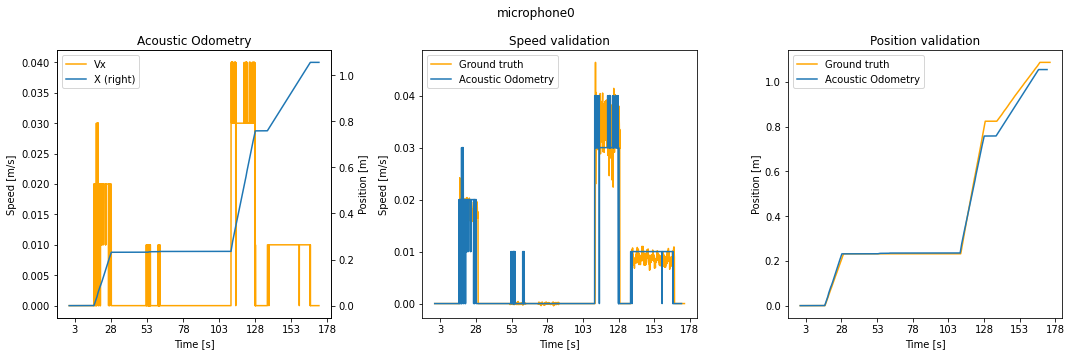

In [103]:
def plot_odometry_evaluation(
    odom: pd.DataFrame,
    ground_truth: pd.DataFrame,
    metrics: Optional[Dict[str, float]] = None,
    *,
    suptitle: Optional[str] = None,
    **subplots_kwargs
    ) -> Tuple[plt.Figure, List[plt.Axes]]:
    fig, axs = plt.subplots(1, 3, **subplots_kwargs)
    axs[0].set_title('Acoustic Odometry')
    ax = odom.plot(ax=axs[0], y=['Vx'], ylabel='Speed [m/s]', color='orange')
    odom.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
    axs[1].set_title('Speed validation')
    ax = ground_truth.plot(
        ax=axs[1],
        y=['Vx'],
        ylabel='Speed [m/s]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['Vx'], label=['Acoustic Odometry'])
    axs[2].set_title('Position validation')
    ax = ground_truth.plot(
        ax=axs[2],
        y=['X'],
        ylabel='Position [m]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['X'], label=['Acoustic Odometry'])
    
    start_timestamp = min(odom.index.min(), ground_truth.index.min())

    @ticker.FuncFormatter
    def to_seconds_from_start(timestamp, pos):
        return f"{int(timestamp - start_timestamp)}"

    for ax in axs:
        ax.xaxis.set_major_formatter(to_seconds_from_start)
        ax.set_xlabel('Time [s]')

    if suptitle is None:
        suptitle = getattr(odom, 'name', 'unnamed')
    if suptitle:
        fig.suptitle(suptitle)
    return fig, axs


_ = plot_odometry_evaluation(odom, ground_truth)

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

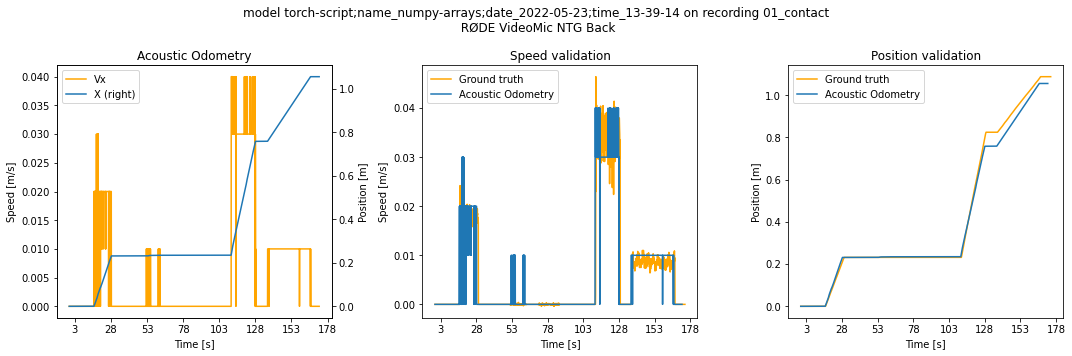

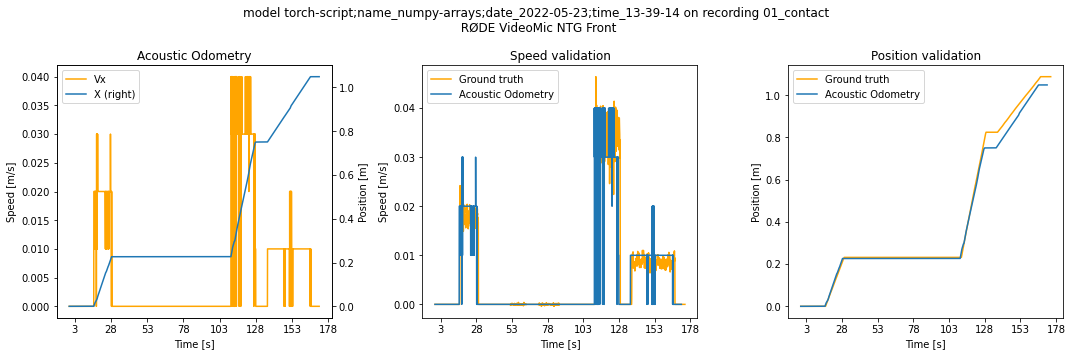

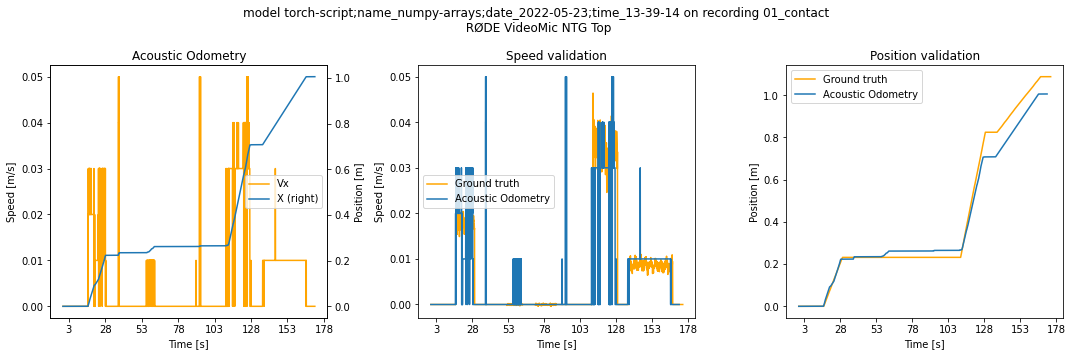

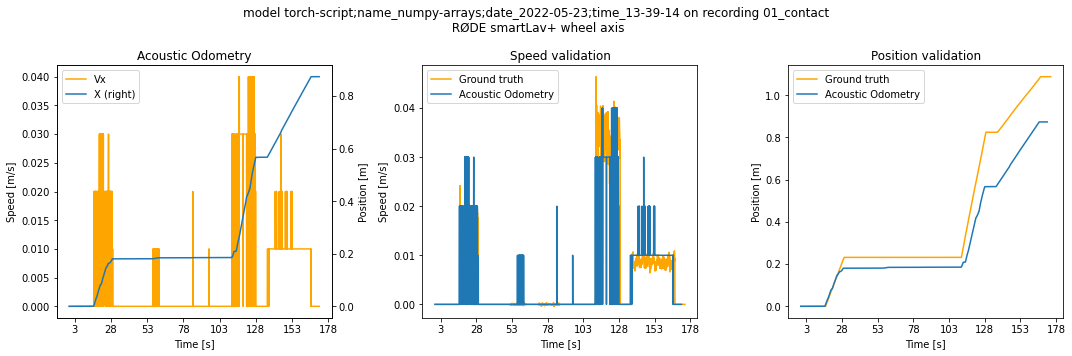

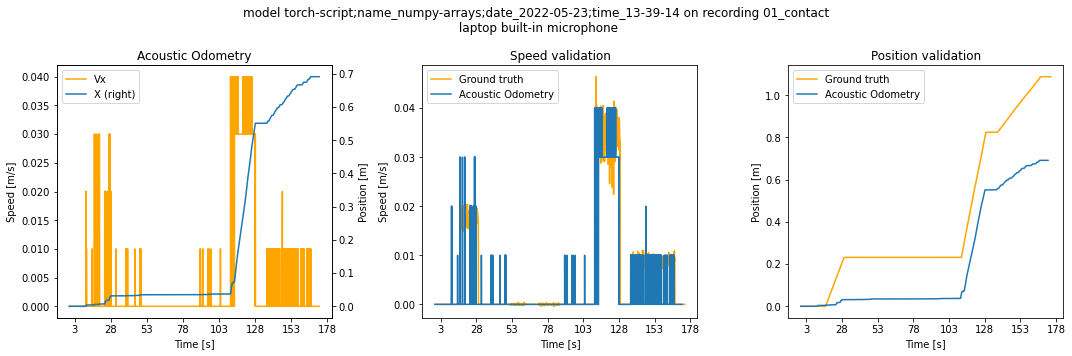

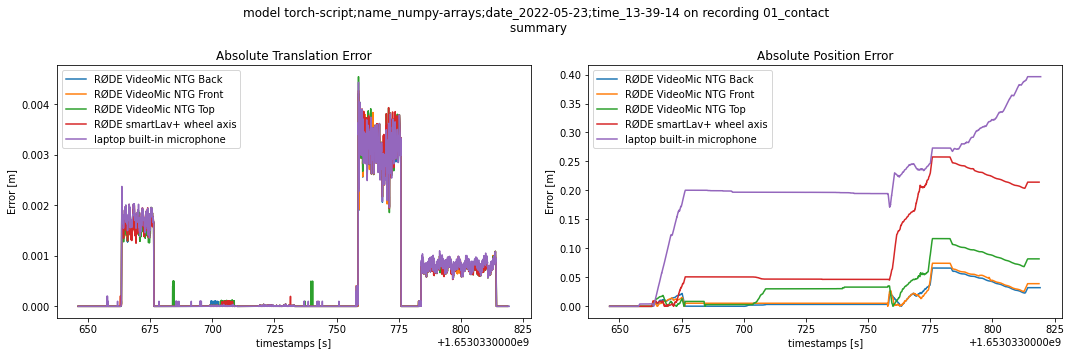

In [104]:
def _evaluate_model(
    model: ao.AO,
    recording: Path,
    plot_filter: Callable[[str, str], bool] = lambda recording, name: False,
    pbars: Optional[Dict[str, tqdm]] = None,
    ) -> dict:
    # Create progress bars if needed
    if pbars is None:
        pbars = {}
    for u in ['files', 'frames']:
        pbars[u] = pbars.get(u) if u in pbars else tqdm(unit=u)
    # Create output folder for plots
    output_folder = recording / str(model)
    output_folder.mkdir(exist_ok=True)
    suptitle = f"model {model} on recording {recording.name}"
    # Get ground truth
    ground_truth = get_recording_ground_truth(recording=recording)
    results = {}
    files = sorted(recording.glob('*.wav'))
    pbars['files'].reset(len(files))
    for wav_file in files:
        pbars['files'].set_description(wav_file.name)
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        odom = get_odometry(wav_file, model, pbar=pbars['frames'])
        metrics = evaluate_odometry(odom, ground_truth)
        results[wav_file.stem] = {
            'odom': odom,
            'metrics': metrics,
            'config': config,
            }
        if plot_filter(recording.name, f"{config['name']}"):
            fig, _ = plot_odometry_evaluation(
                odom,
                ground_truth,
                metrics,
                suptitle=f"{suptitle}\n {config['name']}"
                )
            fig.savefig(output_folder / wav_file.with_suffix('.png').name)
        pbars['files'].update()
    if plot_filter(recording.name, 'summary'):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
        for result in results.values():
            if not plot_filter(
                recording.name,
                f"summary {result['config']['name']}"
                ):
                continue
            # Add Relative Translation Error
            for ax, var, title in zip(
                axs, ['tx_error', 'X_error'],
                ['Absolute Translation Error', 'Absolute Position Error']
                ):
                result['odom'].plot(
                    ax=ax,
                    y=var,
                    label=f"{result['config']['name']}"
                    )
                ax.set_title(title)
                ax.set_ylabel('Error [m]')
                ax.set_xlabel('timestamps [s]')
                ax.legend()
        fig.suptitle(f"{suptitle}\n summary")
    return results


_ = _evaluate_model(
    model, recording, lambda recording, name: 'smartLav+ top' not in name
    )

  0%|          | 0/5 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

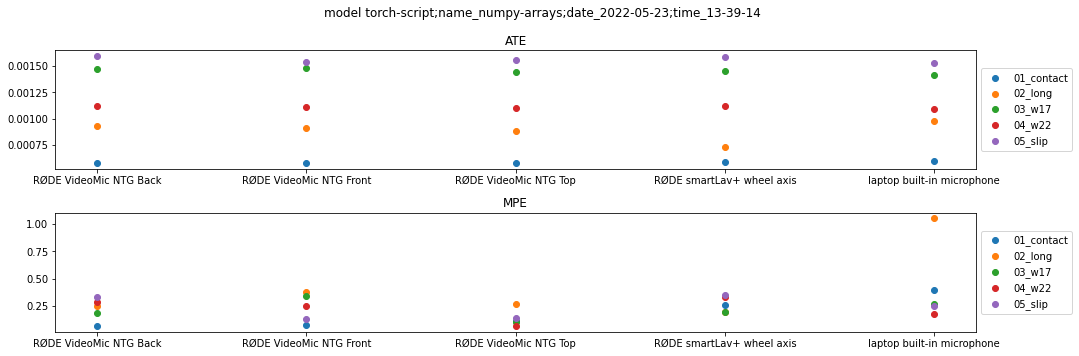

In [93]:
def evaluate_model(
    model: ao.AO,
    recordings: List[Path] = [
        f for f in EVALUATION_FOLDER.iterdir() if f.is_dir()
        ],
    plot_filter: Union[Callable[[str, str], bool],
                       bool] = lambda recording, name: False,
    ) -> pd.DataFrame:
    # Process input
    if not isinstance(recordings, list):
        recordings = [recordings]
    if not callable(plot_filter):
        plot_filter = lambda recording, name: plot_filter
    # Create progress bars
    progress = {
        'recordings': tqdm(total=len(recordings), unit='recordings'),
        'files': tqdm(unit='files'),
        'frames': tqdm(unit='frames'),
        }
    evaluation = pd.DataFrame(columns=['recording', 'device'])
    for recording in recordings:
        progress['recordings'].set_description(recording.name)
        results = _evaluate_model(model, recording, plot_filter, progress)
        # Fill evaluation with results metrics
        for result in results.values():
            _result = pd.DataFrame.from_records([{
                'recording': recording.name,
                'device': f"{result['config']['name']}",
                **result['metrics']
                }])
            evaluation = pd.concat([evaluation, _result], ignore_index=True)
        progress['recordings'].update()
    for pbar in progress.values():
        pbar.close()
    evaluation.set_index(['recording', 'device'], inplace=True)
    # Plot evaluation
    if plot_filter('', 'evaluation'):
        fig, axs = plt.subplots(len(evaluation.columns), 1)
        for ax, column in zip(axs, evaluation.columns):
            for recording, results in evaluation[column].groupby('recording'):
                results = {
                    device: v
                    for (_, device), v in results.to_dict().items()
                    if plot_filter(recording, f"evaluation {column} {device}")
                    }
                ax.scatter(results.keys(), results.values(), label=recording)
            ax.set_title(column)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig.suptitle(f"model {model}")
    return evaluation

evaluation = evaluate_model(
    model,
    plot_filter=lambda recording, name: 'evaluation' in name and
    'smartLav+ top' not in name,
    )

# Results

## Contact No-Contact


  0%|          | 0/1 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

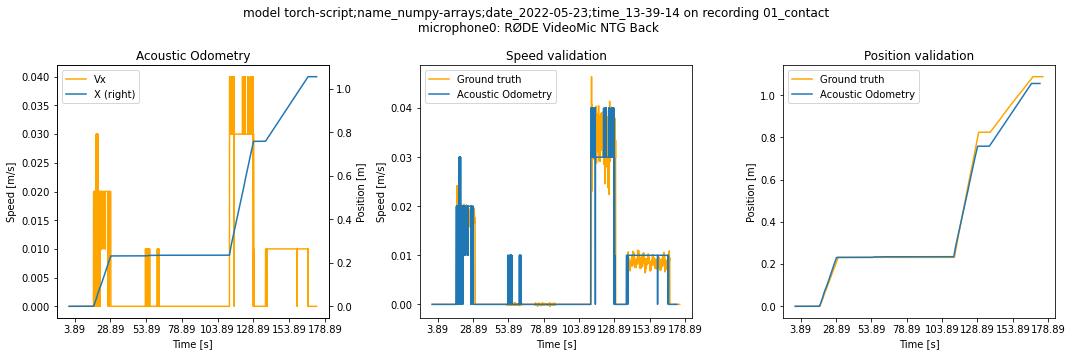

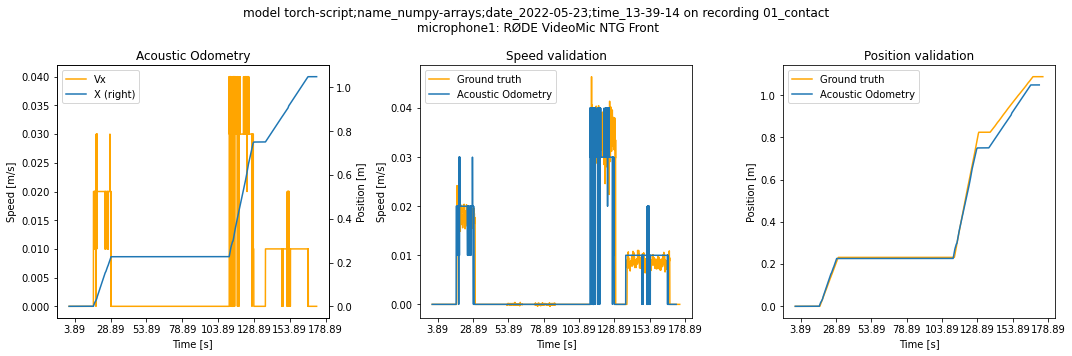

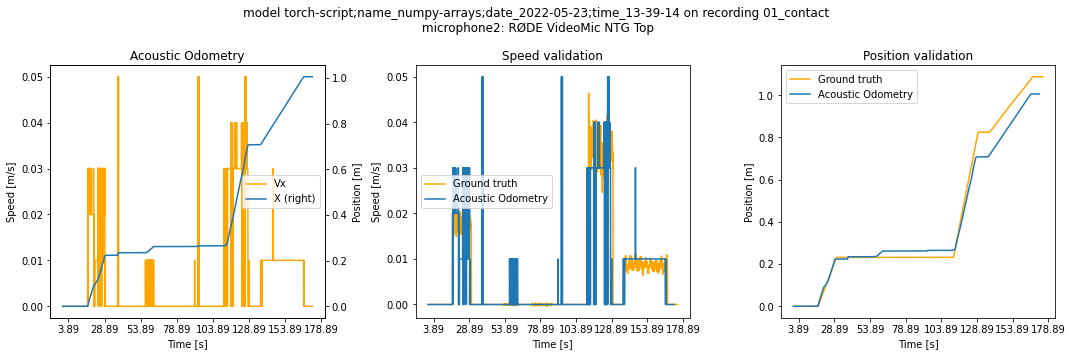

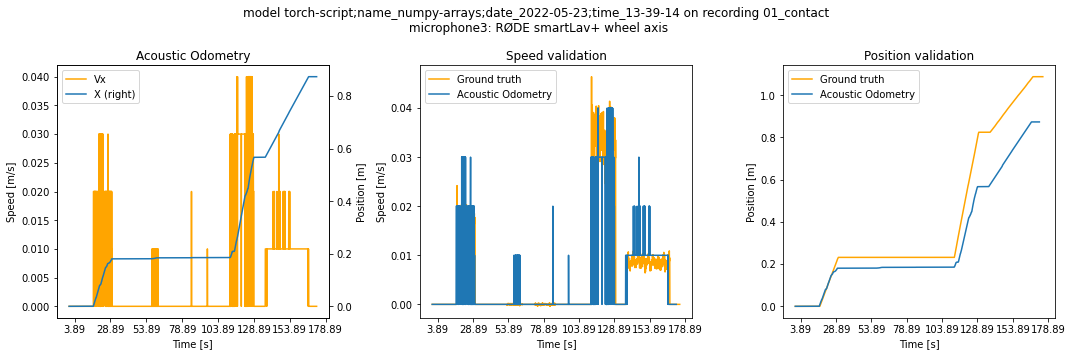

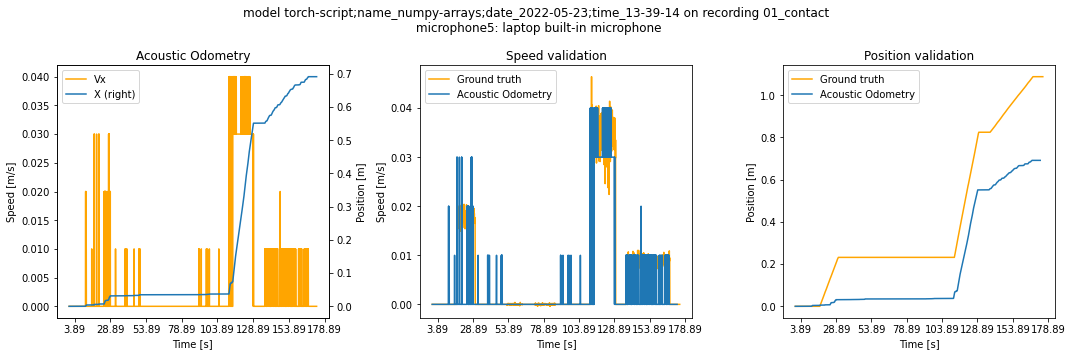

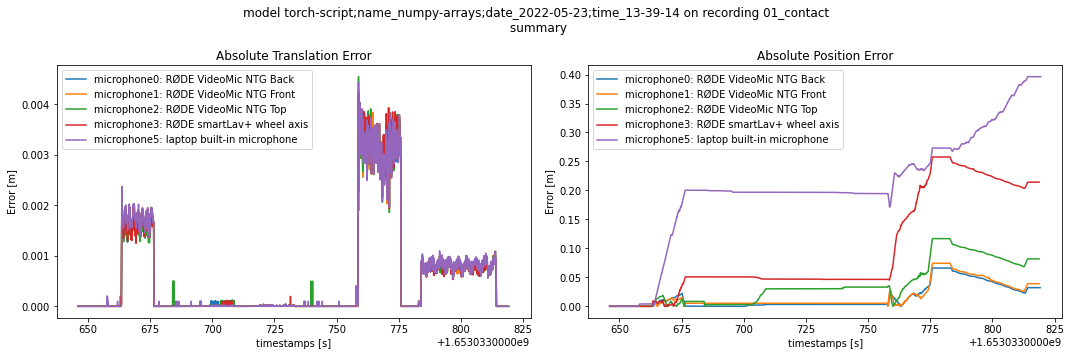

In [94]:
_ = evaluate_model(
    model,
    EVALUATION_FOLDER / '01_contact',
    plot_filter=lambda recording, name: 'evaluation' not in name and
    'smartLav+ top' not in name,
    )

## Long


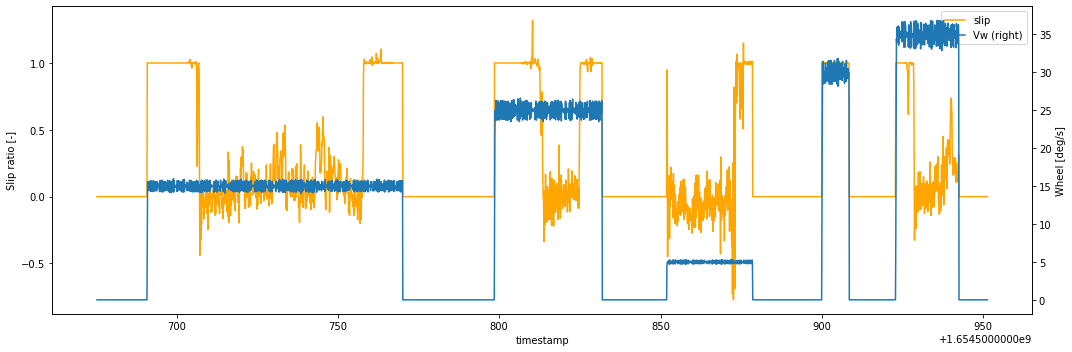

In [95]:
gt = get_recording_ground_truth(EVALUATION_FOLDER / '02_long')
ax = gt.plot(y=['slip'], ylabel='Slip ratio [-]', color='orange')
_ = gt.plot(ax=ax, y=['Vw'], secondary_y=True).set_ylabel('Wheel [deg/s]') 

  0%|          | 0/1 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

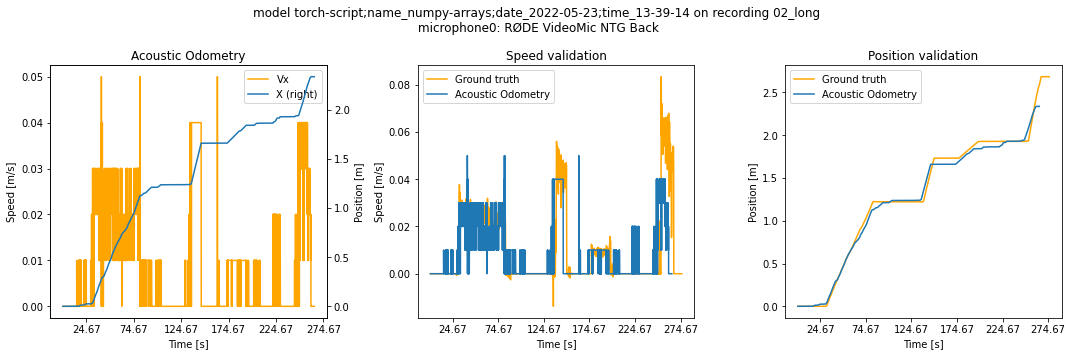

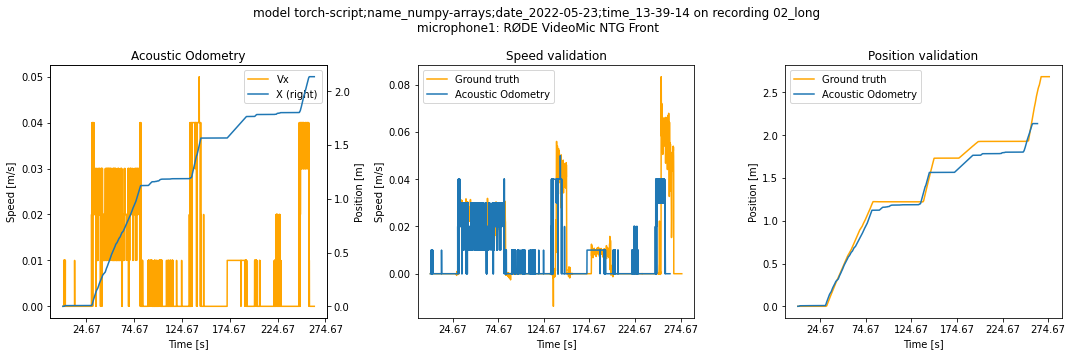

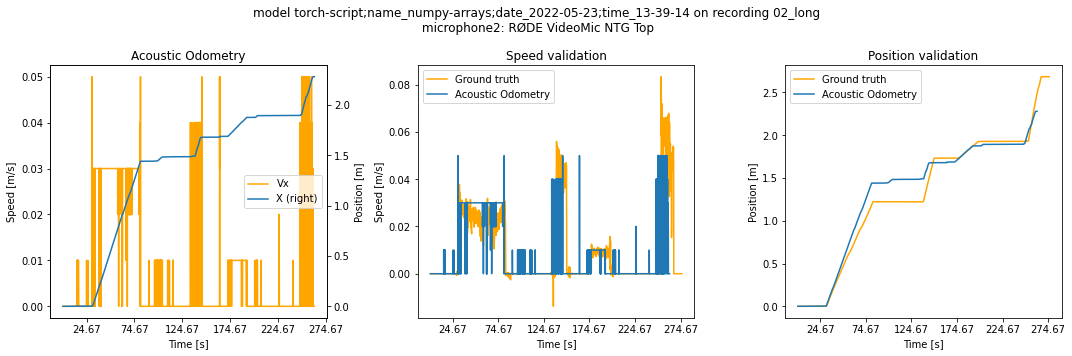

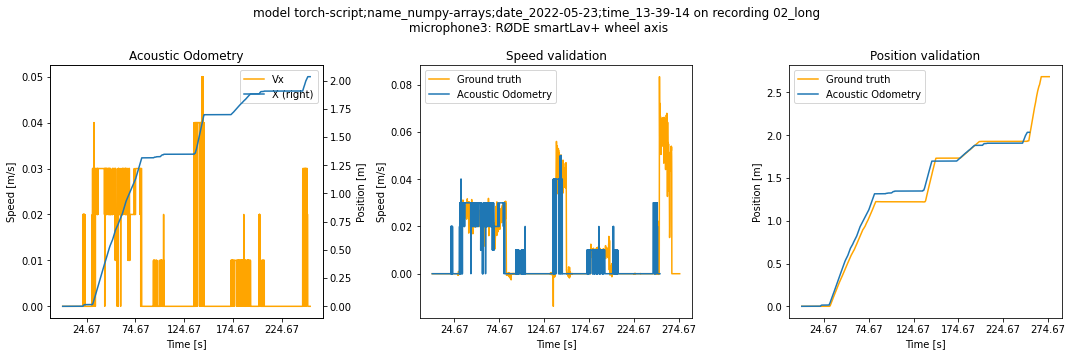

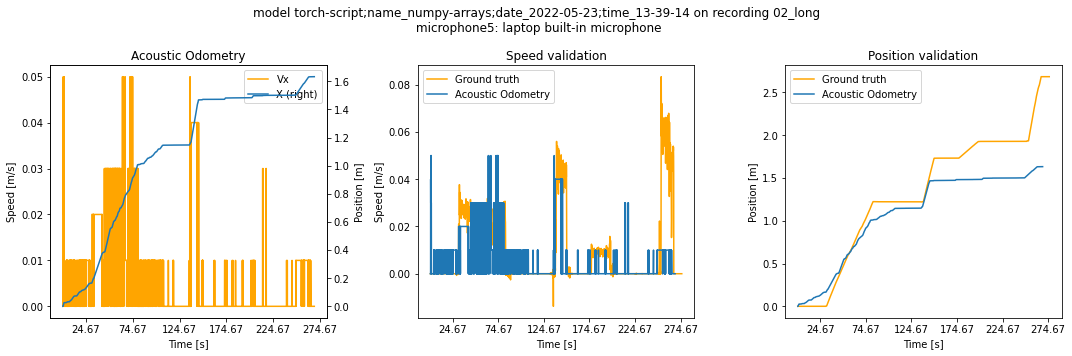

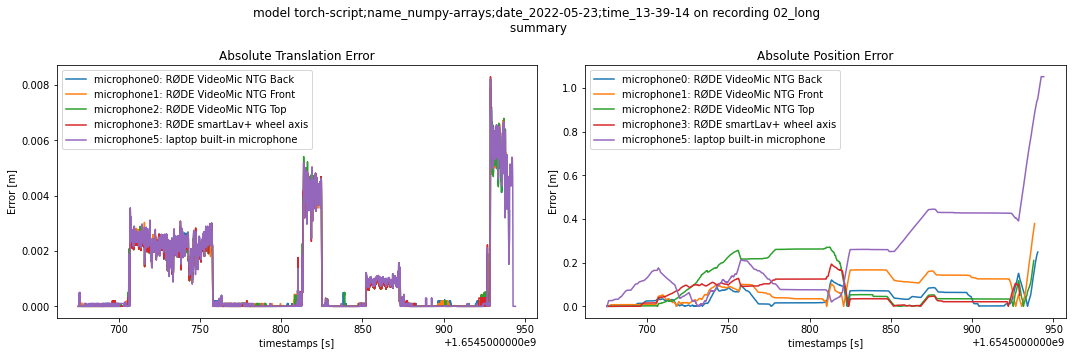

In [96]:
_ = evaluate_model(
    model,
    EVALUATION_FOLDER / '02_long',
    plot_filter=lambda recording, name: 'evaluation' not in name and
    'smartLav+ top' not in name,
    )

## Slow slipping


  0%|          | 0/1 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

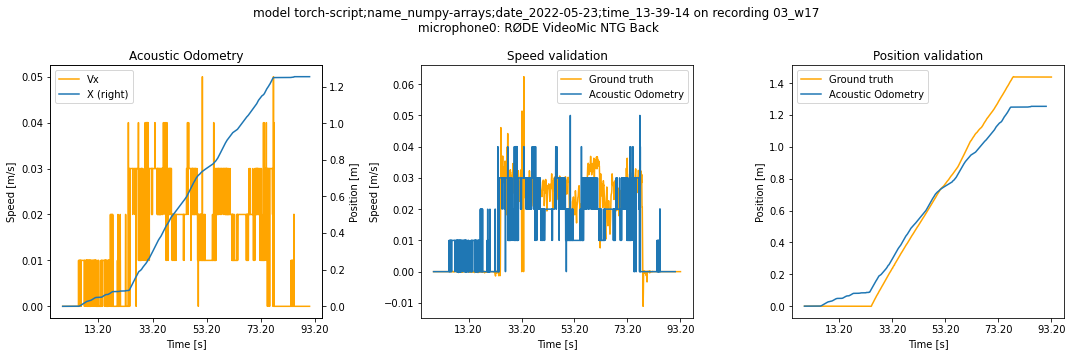

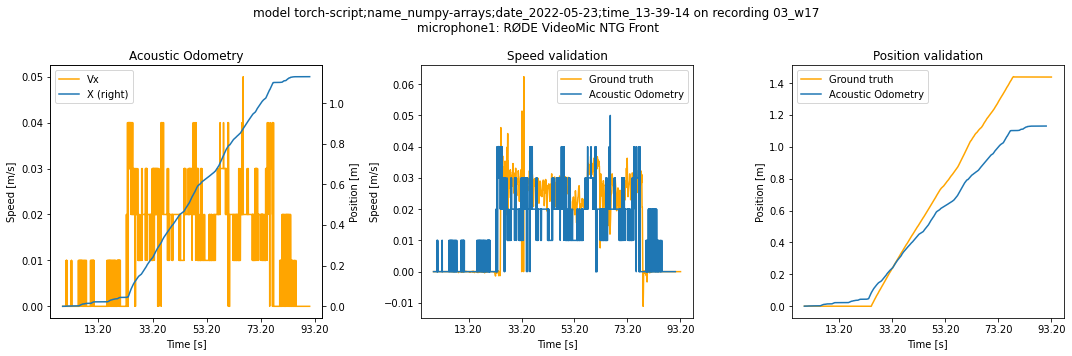

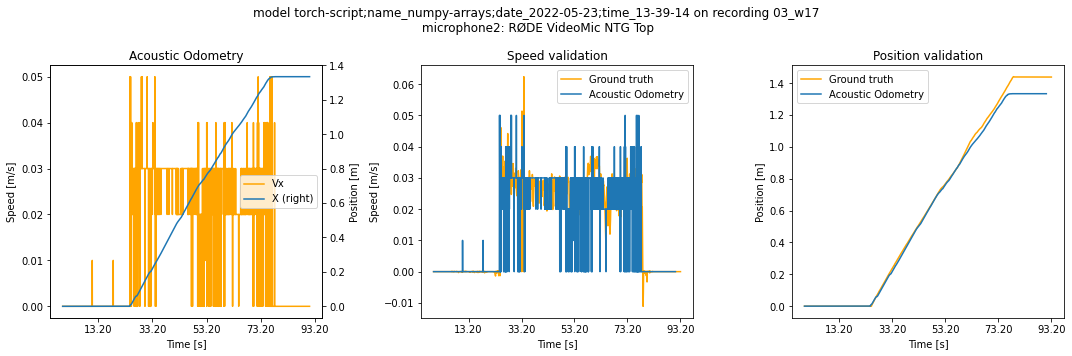

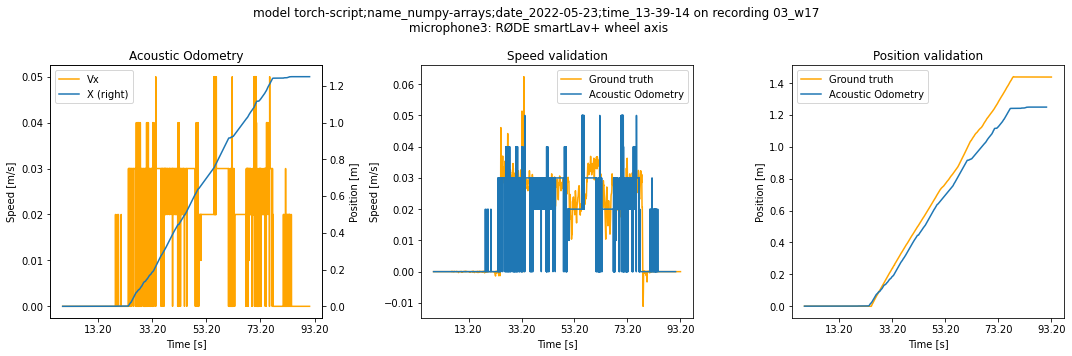

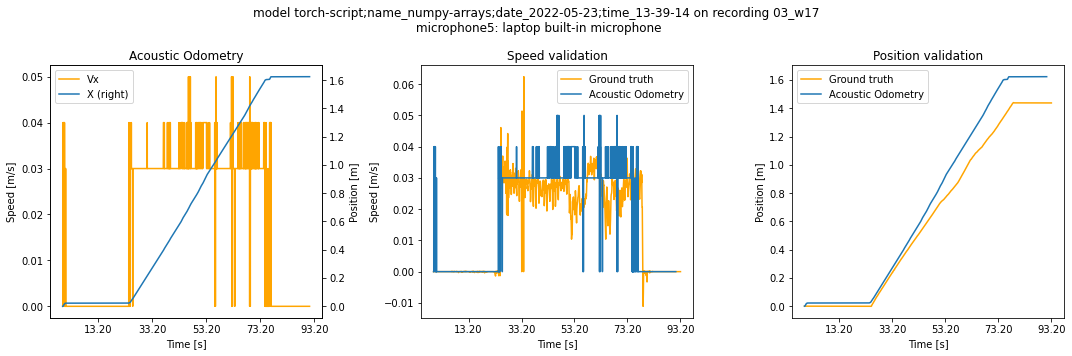

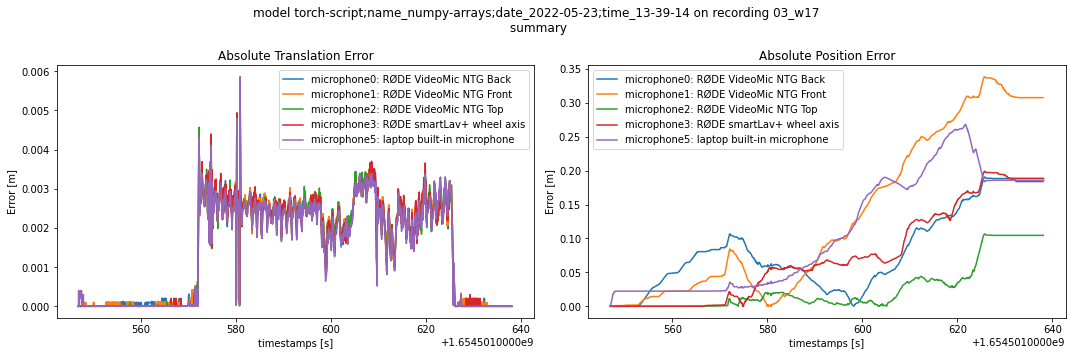

In [97]:
_ = evaluate_model(
    model,
    EVALUATION_FOLDER / '03_w17',
    plot_filter=lambda recording, name: 'evaluation' not in name and
    'smartLav+ top' not in name,
    )

## Fast slipping


  0%|          | 0/1 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

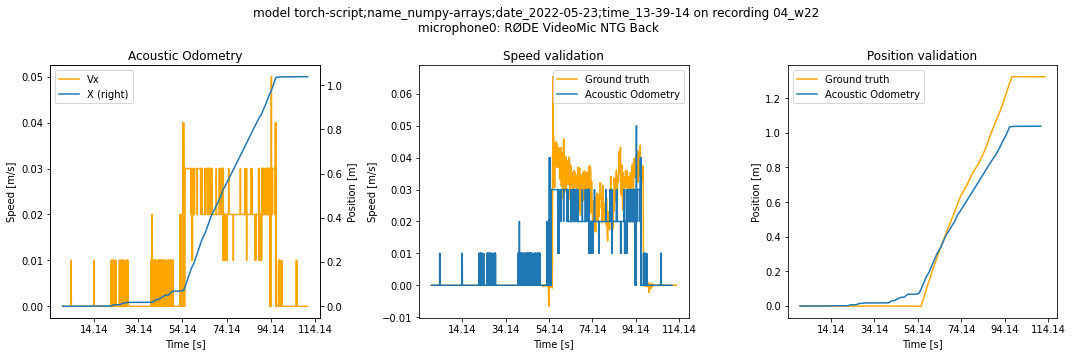

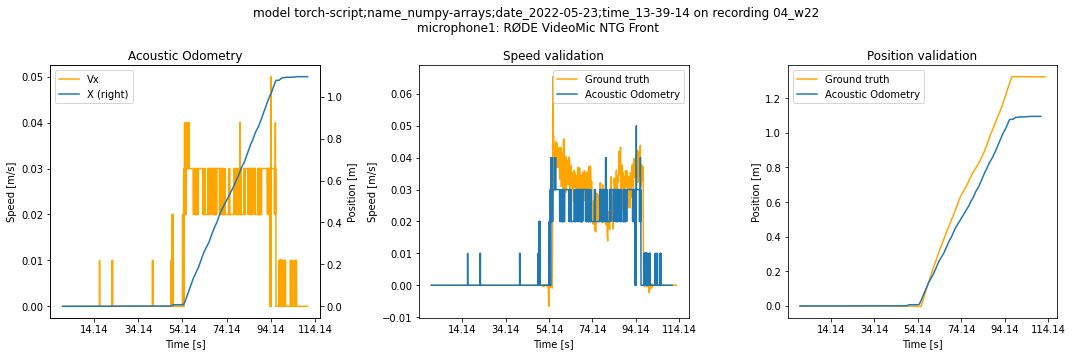

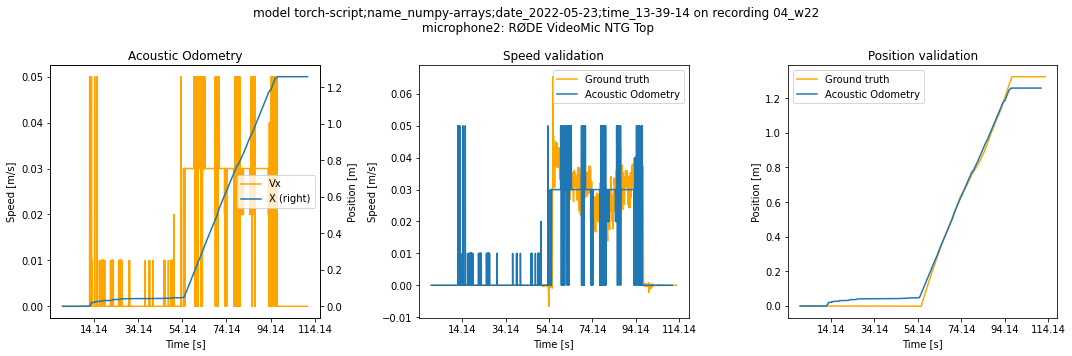

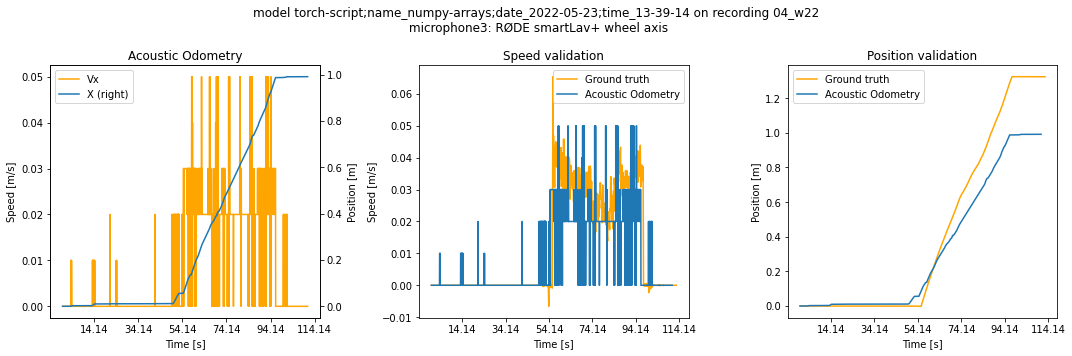

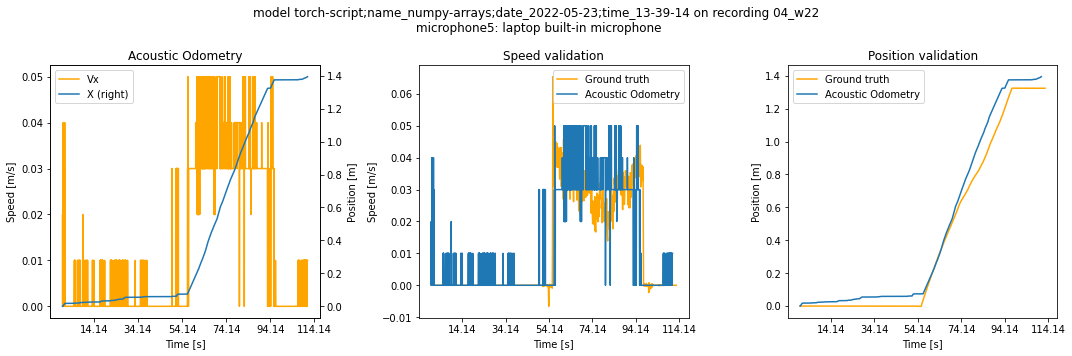

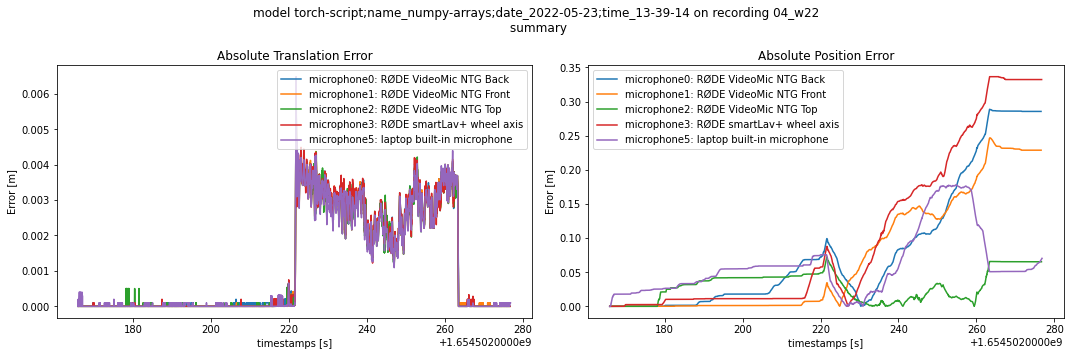

In [98]:
_ = evaluate_model(
    model,
    EVALUATION_FOLDER / '04_w22',
    plot_filter=lambda recording, name: 'evaluation' not in name and
    'smartLav+ top' not in name,
    )

## Strong slipping

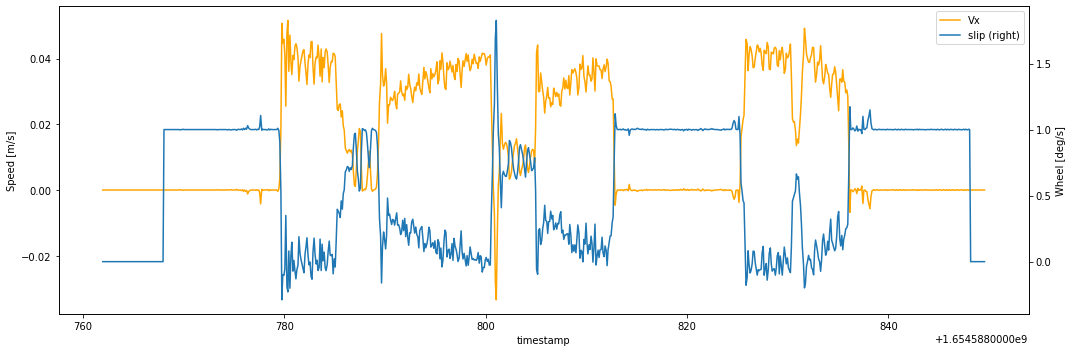

In [99]:
gt = get_recording_ground_truth(EVALUATION_FOLDER / '05_slip')
ax = gt.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
_ = gt.plot(ax=ax, y=['slip'], secondary_y=True).set_ylabel('Wheel [deg/s]') 

  0%|          | 0/1 [00:00<?, ?recordings/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

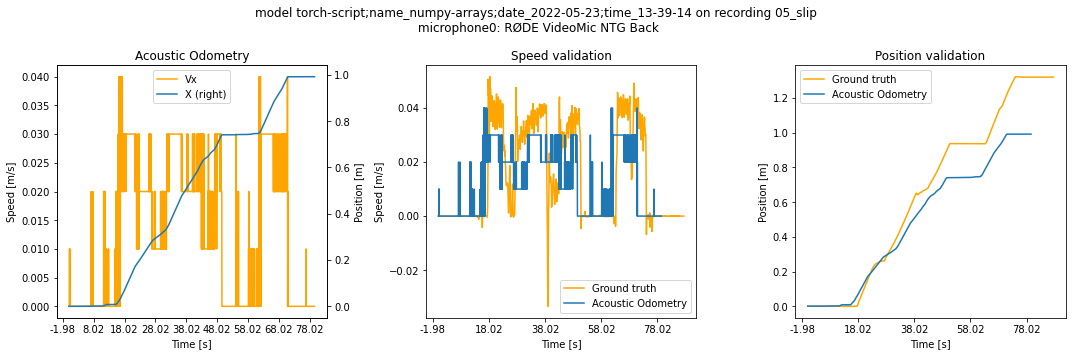

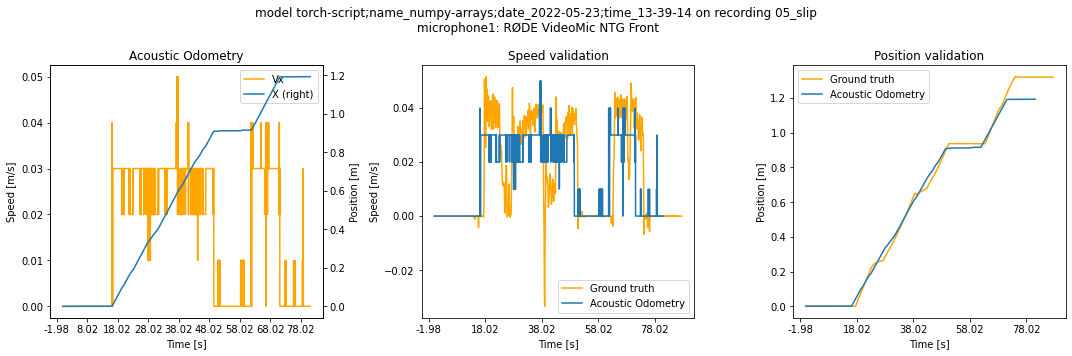

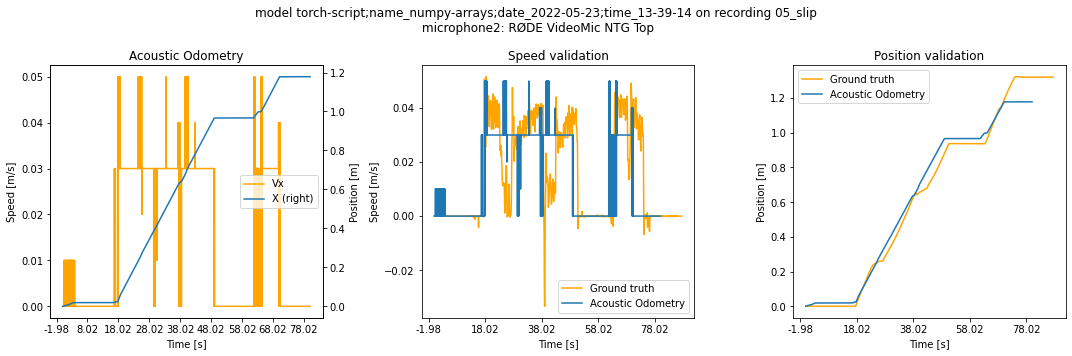

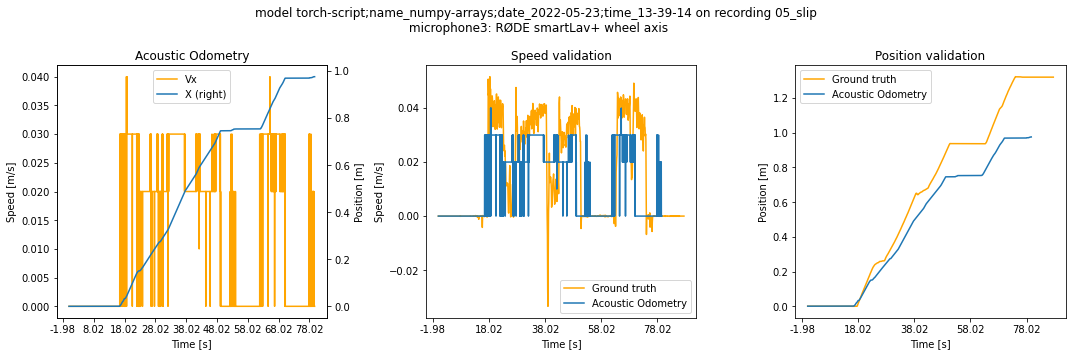

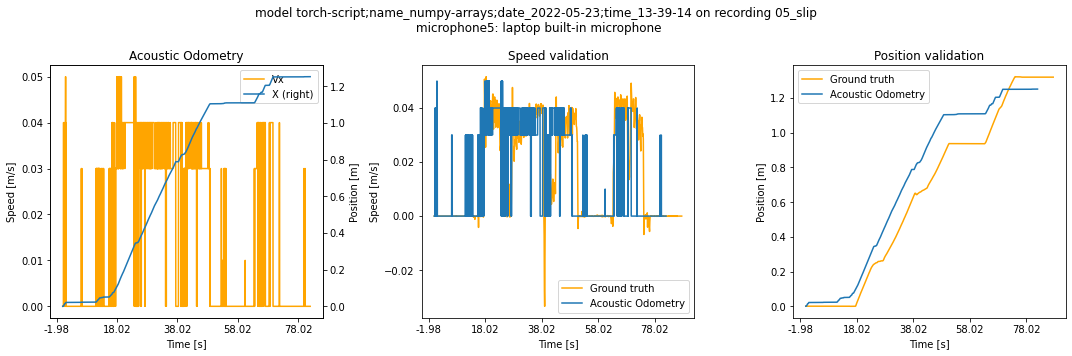

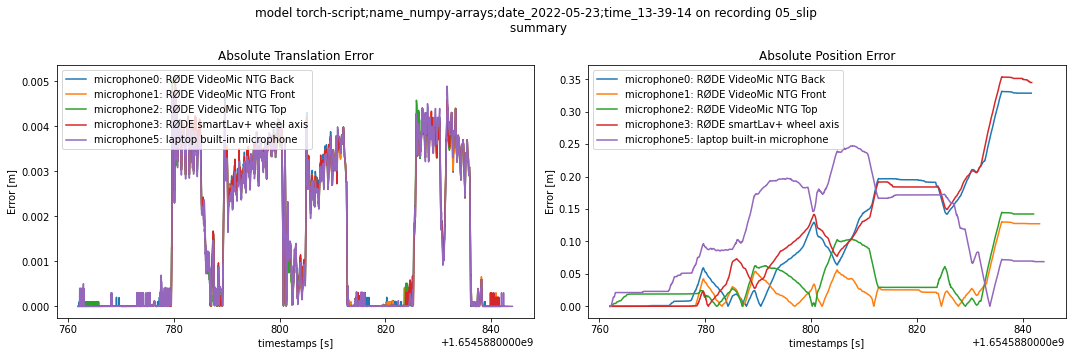

In [100]:
_ = evaluate_model(
    model,
    EVALUATION_FOLDER / '05_slip',
    plot_filter=lambda recording, name: 'evaluation' not in name and
    'smartLav+ top' not in name,
    )